In [2]:
import sys
import numpy as np
import pydicom as pd
import cv2 as cv
from math import sqrt
from scipy import ndimage
from skimage.draw import ellipse
from skimage.transform import resize
from skimage.feature import canny
from skimage import exposure, io, transform
from matplotlib import cm, image, pyplot as plt
from skimage.color import gray2rgb, rgb2hsv, rgb2lab, rgb2xyz, rgb2yuv, gray2rgba, rgb2gray, rgba2rgb
from skimage.util import img_as_ubyte
from skimage import data, img_as_float
from scipy.integrate import trapz, simps
from skimage.segmentation import felzenszwalb, slic, find_boundaries, random_walker, quickshift
from skimage.filters import threshold_otsu, unsharp_mask, gaussian, sobel
from skimage.filters.edges import convolve
from skimage.filters.rank import median, maximum, minimum ,autolevel_percentile, autolevel
from skimage.morphology import erosion, dilation, closing, opening, disk
from skimage.restoration import denoise_bilateral
from ipywidgets import interact, IntSlider, interactive, fixed, FloatSlider

In [3]:
def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');

In [3]:
def f64_2_u8(img_stack):
    
    if len(img_stack.shape)==2:
        stretched = 255 * (img_stack / max(np.unique(img_stack)))
        new_stack = stretched.astype(np.uint8)
    
    elif len(img_stack.shape)==3:
        new_stack = np.empty(img_stack.shape, np.uint8)
        for i in range(len(img_stack)):
            #stretched = 255 * (img_stack[i] / max(np.unique(img_stack[i])))
            stretched = 255 * (img_stack[i] / max(np.unique(img_stack)))
            new_stack[i] = stretched.astype(np.uint8)
    
    else:
        raise ValueError('Array of wrong number of dimentions given to f64_2_u8')
    
    return(new_stack)

# Importation

0 	 238 	 226 	 2.0
1 	 961 	 652 	 387.75
2 	 22230 	 12073 	 14638.84
3 	 59853 	 34490 	 42073.5
4 	 58039 	 41820 	 45711.39
5 	 44366 	 35359 	 36071.11
6 	 41602 	 34925 	 34988.33
7 	 39015 	 33135 	 32896.24
8 	 37469 	 32379 	 31850.98
9 	 37499 	 32475 	 31853.49
10 	 36884 	 32438 	 31556.68
11 	 37154 	 32623 	 31698.27
12 	 36889 	 32451 	 31614.99
13 	 37211 	 32816 	 31864.34
14 	 37886 	 33097 	 32327.35
15 	 37757 	 33245 	 32280.42
16 	 37950 	 33208 	 32412.56
17 	 38351 	 33419 	 32696.12
18 	 38429 	 33856 	 32889.82
19 	 38754 	 34077 	 33054.4
20 	 38659 	 33692 	 32779.12
21 	 39314 	 34060 	 33393.05
22 	 38948 	 34044 	 33190.87
23 	 39253 	 34565 	 33557.09
24 	 39229 	 34913 	 33831.2
25 	 39502 	 34930 	 33792.95
26 	 39872 	 34452 	 33739.26
27 	 40162 	 34854 	 34099.8
28 	 40136 	 34960 	 34112.42
29 	 40113 	 35049 	 34036.46
30 	 40365 	 35418 	 34400.71
31 	 40595 	 35469 	 34544.08
32 	 40723 	 35561 	 34608.91
33 	 40670 	 35595 	 34727.07
34 	 4118

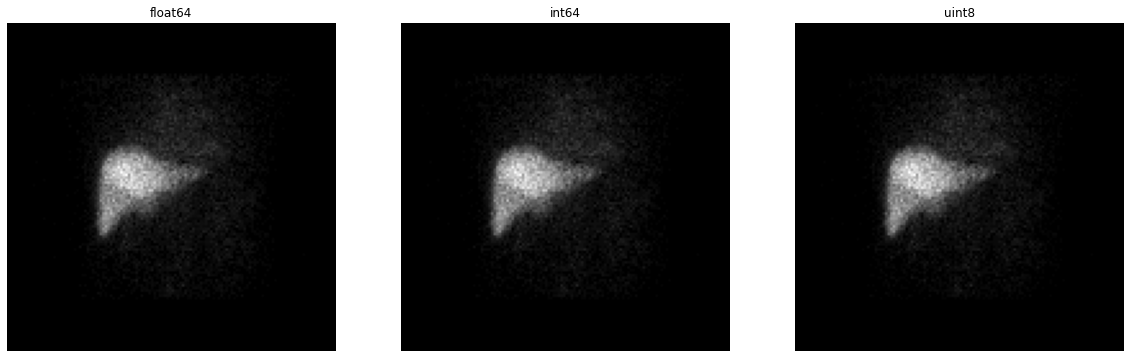

In [55]:
ant = pd.dcmread("Images/Dyn_Ant_HBS3.dcm")
post = pd.dcmread("Images/Dyn_Post_HBS3.dcm")
ant_pix = ant.pixel_array
post_pix = post.pixel_array[:,:,::-1]
mean = (ant_pix*post_pix)**(1/2)
for i in range(len(mean)):
    print(i, '\t', np.sum(ant_pix[i]), '\t', np.sum(post_pix[i]), '\t', round(np.sum(mean[i]),2))
print('Tot', '\t', np.sum(ant_pix), np.sum(post_pix), '', round(np.sum(mean),2))
    
print("Number of levels as {} =".format(mean.dtype), len(np.unique(mean)))

mean_int = np.rint(mean).astype(int)
#mean_int = mean / max(np.unique(mean))
#mean_int = 255 * mean_int
#mean_int = mean_int.astype(np.uint8)
print("Number of levels as {} =".format(mean_int.dtype), len(np.unique(mean_int)))

mean_norm = mean / max(np.unique(mean))
mean_norm = 255 * mean_norm
mean_norm = mean_norm.astype(np.uint8)
print("Number of levels as {} =".format(mean_norm.dtype), len(np.unique(mean_norm)))


plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.title(str(mean.dtype))
plt.axis('off')
plt.imshow(mean[25],cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title(str(mean_int.dtype))
plt.axis('off')
plt.imshow(mean_int[25],cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title(str(mean_norm.dtype))
plt.axis('off')
plt.imshow(mean_norm[25],cmap=plt.cm.gray)
plt.show()

In [56]:
@interact(i=IntSlider(min=0, max=35, step=1, value=0),
         mask=fixed(None), shift=fixed(None), hist=fixed(True))

def show_im(i, mask, shift, hist=False):
    if shift and shift[i]:
        mask = ndimage.shift(mask, [shift[i],0])
        mask = closing(mask,disk(3))
        mask = np.ma.masked_where(mask==0, mask)
    plt.figure(figsize=[15,15])
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title('Ant')
    plt.imshow(ant_pix[i,:,:],cmap=plt.cm.gray)
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title('Post')
    plt.imshow(post_pix[i,:,:],cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title('Mean')
    plt.imshow(mean[i,:,:],cmap=plt.cm.gray)
    if mask is not None:
        plt.imshow(mask, cmap='coolwarm', alpha = 0.4)
    if hist:
        plt.figure(figsize=[15,6])
        h = plt.hist(mean[i,:,:].flatten(), bins=range(256), density=False, log=True)

interactive(children=(IntSlider(value=0, description='i', max=35), Output()), _dom_classes=('widget-interact',…

# Liver segmentation

(128, 128)
float64
Number of levels of last img = 476 (from 0.0 to 48.99)
(128, 128)
float64
Number of levels of avg = 5026 (from 0.0 to 38.19)
Number of levels of avg as uint8 = 243 (from 0 to 255)


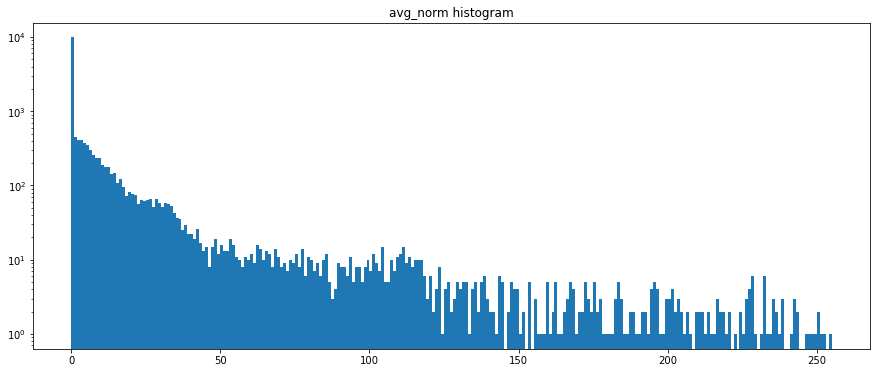

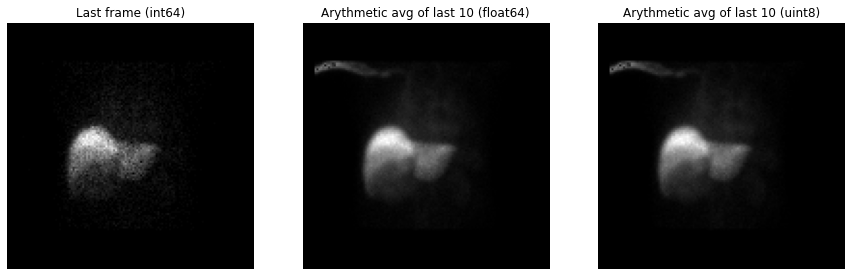

In [6]:
#Build avg of last 10

img = mean[35,:,:]
print(img.shape)
print(img.dtype)
print("Number of levels of last img = {} (from {} to {:.2f})".format(len(np.unique(img)),min(np.unique(img)),max(np.unique(img))))
img = img.astype(int)

avg = np.zeros(img.shape, dtype=np.float64)
for i in range(len(mean[-15:])):
    avg += mean[-i]
avg = avg/15
print(avg.shape)
print(avg.dtype)
print("Number of levels of avg = {} (from {} to {:.2f})".format(len(np.unique(avg)),min(np.unique(avg)),max(np.unique(avg))))

avg_norm = 255 * (avg / max(np.unique(avg)))
avg_norm = avg_norm.astype(np.uint8)
print("Number of levels of avg as {} = {} (from {} to {})".format(avg_norm.dtype, len(np.unique(avg_norm)),min(np.unique(avg_norm)),max(np.unique(avg_norm))))
plt.figure(figsize=[15,6])
plt.title('avg_norm histogram')
h = plt.hist(avg_norm.flatten(), bins=range(256), density=False, log=True)

plt.figure(figsize=[15,6])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Last frame ({})".format(img.dtype))
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg.dtype))
plt.imshow(avg, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg_norm.dtype))
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.show()

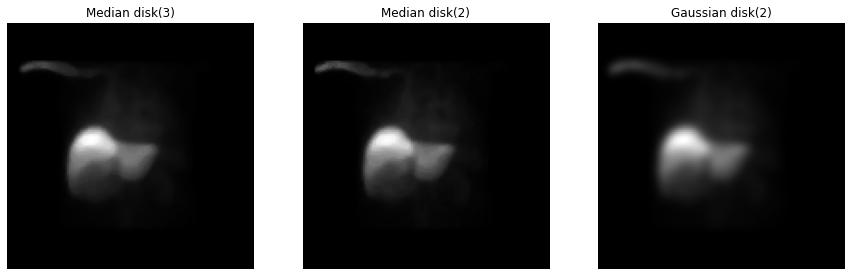

In [7]:
img_median = median(avg_norm, disk(3))
img_gauss = gaussian(avg_norm,2)

plt.figure(figsize=[15,6])
plt.subplot(1,3,1)
plt.title("Median disk(3)")
plt.axis('off')
plt.imshow(img_median, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Median disk(2)")
plt.axis('off')
plt.imshow(median(avg_norm, disk(2)), cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Gaussian disk(2)")
plt.axis('off')
plt.imshow(img_gauss, cmap=plt.cm.gray)
plt.show()

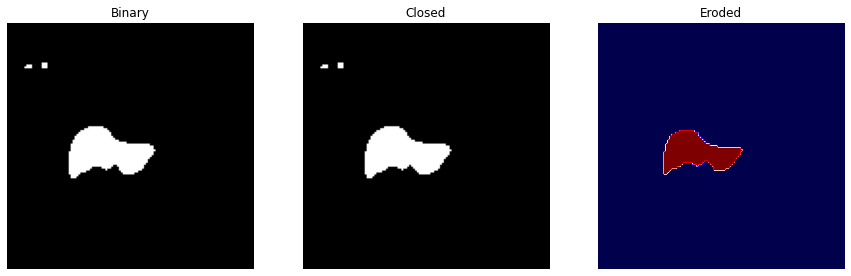

In [8]:
thresh = threshold_otsu(img_median)

binary = img_median > thresh
closed = closing(binary, disk(2))
eroded = erosion(binary, disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
plt.imshow(mean[35], cmap=plt.cm.gray)
plt.imshow(eroded, cmap='seismic')
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/_percentile.py:40: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


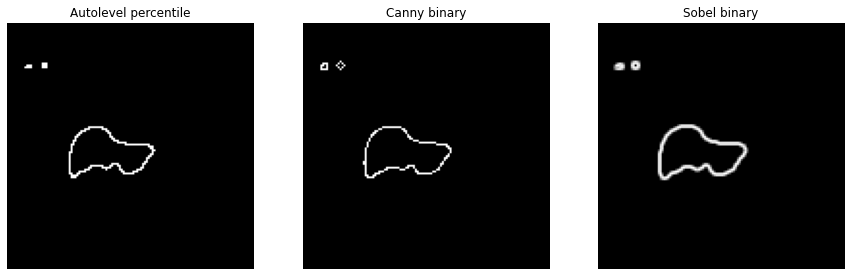

In [9]:
from skimage import img_as_uint

canny_binary = canny(binary)
sobel_binary = sobel(binary)
border = autolevel_percentile(img_as_uint(binary),disk(2),p0=.1,p1=.9)

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentile")
plt.imshow(border, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny binary")
plt.imshow(canny_binary, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel binary")
plt.imshow(sobel_binary, cmap=plt.cm.gray)
plt.show()

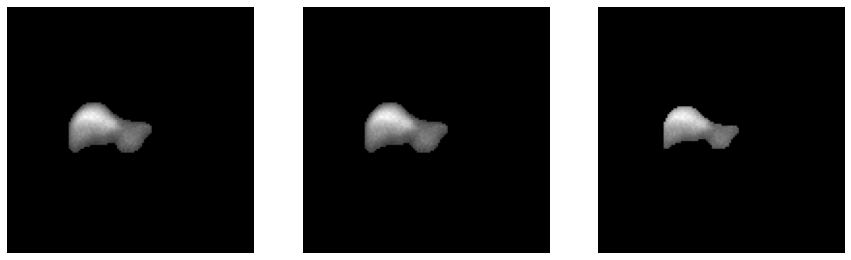

In [377]:
masked_img = avg_norm * binary
masked_closed = avg_norm * closed
masked_eroded = avg_norm * eroded

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(masked_img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(masked_closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(masked_eroded, cmap=plt.cm.gray)
plt.show()

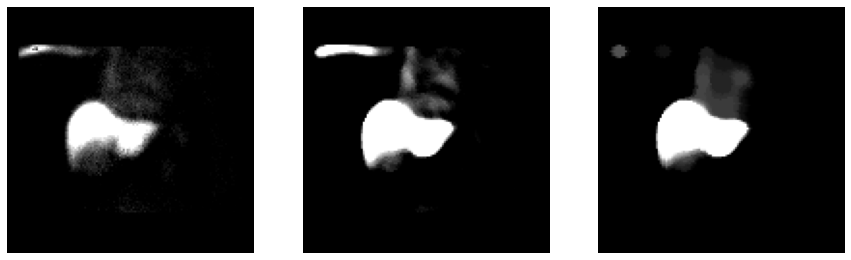

In [389]:
img_local1 = unsharp_mask(avg_norm, radius=20, amount=3)
img_local2 = unsharp_mask(img_median, radius=20, amount=15)
img_local_morpho = closing(opening(img_local2, disk(3)), disk(5))


plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_local1, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img_local2, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(img_local_morpho, cmap=plt.cm.gray)
plt.show()

(array([    0, 65535], dtype=uint16), array([16278,   106]))
(array([False,  True]), array([16293,    91]))
(array([0.        , 0.25      , 0.55901699, 0.70710678, 0.75      ,
       0.79056942]), array([16164,    70,    38,    42,    32,    38]))


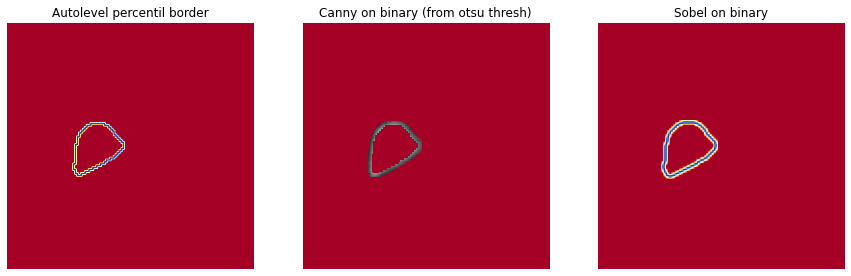

In [291]:
ma1 = np.ma.masked_where(border==1, border)
ma2 = np.ma.masked_where(canny_binary==1, canny_binary)
ma3 = np.ma.masked_where(sobel_binary==1, sobel_binary)
print(np.unique(border, return_counts=True))
print(np.unique(canny_binary, return_counts=True))
print(np.unique(sobel_binary, return_counts=True))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentil border")
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.imshow(ma1, cmap='RdYlBu')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny on binary (from otsu thresh)")
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.imshow(ma2, cmap='RdYlBu')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel on binary")
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.imshow(ma3, cmap='RdYlBu')
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


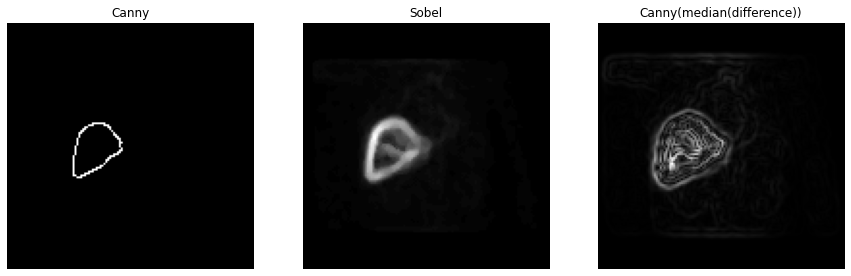

In [293]:
can = canny(avg_norm, sigma=1.5, low_threshold=70, high_threshold=200)
sob = median(sobel(avg_norm),disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Canny")
plt.imshow(can, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Sobel")
plt.imshow(sob, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Canny(median(difference))")
plt.imshow(sobel(diff_med), cmap=plt.cm.gray)
plt.show()

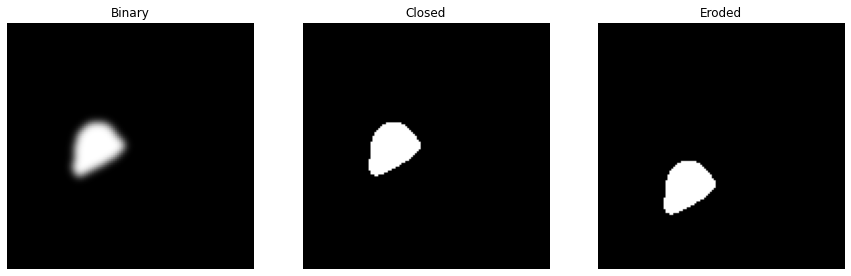

In [294]:
#binary edge smoohing
binary_gauss = gaussian(binary,2)
thresh_bis = threshold_otsu(binary_gauss)
binary_sm = binary_gauss > thresh_bis

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary_gauss, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
#plt.imshow(mean[25], cmap=plt.cm.gray)
#plt.imshow(np.ma.masked_where(binary_sm==0, binary_sm), cmap="coolwarm")

matrix = transform.EuclideanTransform(translation = (0, 20))
binary_sm = transform.warp(binary_sm, matrix.inverse)

#binary_sm = ndimage.shift(binary_sm, [20,-10])
#binary_sm = closing(binary_sm,disk(3))
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.show()

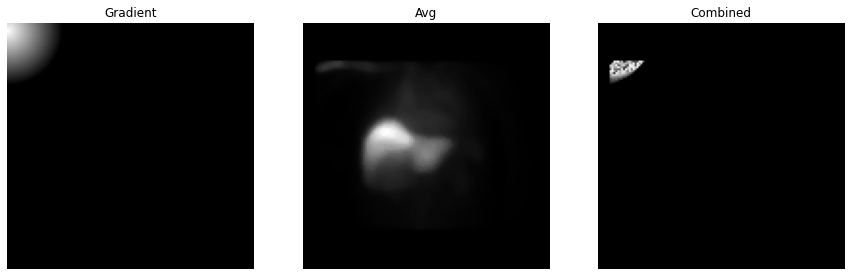

In [375]:
#circular gradient
def draw_grad(innerColor, outerColor, center=None):
    imgsize = (128,128)
    if center is None: center = (imgsize[0]/2, imgsize[1]/2)
    img = np.zeros(imgsize, dtype=np.uint8)

    for x in range(imgsize[0]):
        for y in range(imgsize[1]):
            #Find the distance to the center
            distanceToCenter = sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            #Make it on a scale from 0 to 1
            distanceToCenter = float(distanceToCenter) / (sqrt(2) * 20)
            #Calculate color values
            if distanceToCenter > 1: c=outerColor
            else: c = outerColor * distanceToCenter + innerColor * (1 - distanceToCenter)
            #Place the pixel
            img[y,x]=int(c)
    return(img)


def cluster_segmentation(k, r, ell, blood_med):
    q = quickshift(gray2rgb(blood_med*ell), kernel_size=k, ratio=r)
    lightest = 0
    best_avg = 0
    for i in np.unique(q):
        avg=np.mean(blood_med[q==i])
        #print('Cluster {} avg : {:.2f}'.format(i, avg))
        if avg>best_avg: 
            lightest=i
            best_avg=avg

grad = draw_grad(255,0,(0,4))
plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Gradient")
plt.axis('off')
plt.imshow(grad, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Avg")
plt.axis('off')
plt.imshow(img_median, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Combined")
plt.axis('off')
plt.imshow(((img_median*grad)**(1/2)), cmap=plt.cm.gray)
plt.show()

# Blood pool segmentation

(128, 128)
Number of levels as uint8 = 111


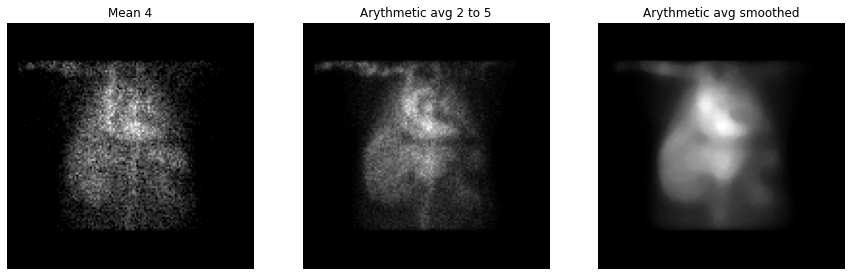

In [10]:
avg_blood = np.zeros(img.shape, dtype=np.float64)
for i in ant_pix[2:7]:
    avg_blood += i
avg_blood = avg_blood/len(ant_pix[2:7])
print(avg_blood.shape)

avg_blood_norm = 255 * (avg_blood / max(np.unique(avg_blood)))
avg_blood_norm = avg_blood_norm.astype(np.uint8)
print("Number of levels as {} =".format(avg_blood_norm.dtype), len(np.unique(avg_blood_norm)))

blood_med = median(avg_blood_norm, disk(3))
blood_med = gaussian(median(avg_blood_norm, disk(5)), 0)
#blood_med = median(gaussian(avg_blood_norm, 2), disk(2))
#blood_med = maximum(gaussian(avg_blood_norm, 3), disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Mean 4")
plt.imshow(mean[3], cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 2 to 5")
plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg smoothed")
plt.imshow(blood_med, cmap=plt.cm.gray)
plt.show()

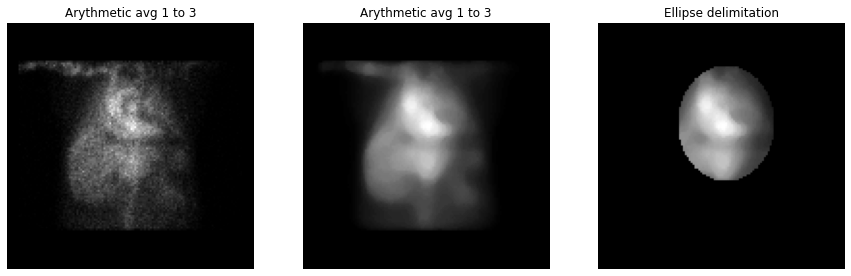

In [11]:
#region delimitation
ell = np.zeros((128, 128), dtype=np.uint8)
rr, cc = ellipse(52, 66, 30, 25, rotation=np.deg2rad(0))
ell[rr, cc] = 1

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(blood_med, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Ellipse delimitation")
plt.imshow(blood_med*ell, cmap=plt.cm.gray)
plt.show()

In [12]:
#thresh segmentation
@interact(t=FloatSlider(min=-1, max=1, step=0.01, value=0.1),  
          ell=fixed(ell),
          blood_med=fixed(blood_med))

def thresh_segmentation(t, ell, blood_med):
    otsu = threshold_otsu(blood_med*ell)
    mask = blood_med*ell>otsu+t
    mask = opening(mask, disk(5))
    #mask = closing(mask, disk(2))
    plt.figure(figsize=[15,15])
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Arythmetic avg 1 to 3")
    plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("Mask")
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("Segmented")
    plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
    plt.imshow(np.ma.masked_where(mask==1, mask), cmap='RdYlBu')

interactive(children=(FloatSlider(value=0.1, description='t', max=1.0, min=-1.0, step=0.01), Output()), _dom_c…

In [13]:
#thresh unsharp
@interact(rad=IntSlider(min=0, max=50, step=1, value=10),  
          am=IntSlider(min=0, max=50, step=1, value=10),
          thresh=FloatSlider(min=0, max=1, step=0.01, value=0.9),
          ell=fixed(ell),
          avg=fixed(blood_med))

def unsharp_segmentation(rad, am, thresh, ell, avg):
    #avg = 255*avg/max(np.unique(avg))
    #print(min(np.unique(avg)),max(np.unique(avg)))
    blood2 = unsharp_mask(avg, radius=rad, amount=am)
    #b_thresh = threshold_otsu(blood_med*ell)
    b_mask = blood2*ell > thresh
    b_mask = opening(b_mask, disk(3))
    b_mask = closing(b_mask, disk(3))
    can = canny(b_mask)

    plt.figure(figsize=[18,8])
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.title("avg med")
    plt.imshow(avg, cmap=plt.cm.gray)
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.title("Unsharp mask on median")
    plt.imshow(blood2, cmap=plt.cm.gray)
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.title("Binary thresh")
    plt.imshow(b_mask, cmap=plt.cm.gray)
    plt.subplot(1,4,4)
    plt.axis('off')
    plt.title("Binary thresh")
    plt.imshow(ant_pix[4,:,:], cmap=plt.cm.gray)
    plt.imshow(can, cmap='bwr', alpha=0.2)
    #plt.imshow(np.ma.masked_where(can==0, can), cmap = 'RdYlBu')
    plt.show()

interactive(children=(IntSlider(value=10, description='rad', max=50), IntSlider(value=10, description='am', ma…

In [57]:
from skimage.feature import greycomatrix
from skimage.metrics import structural_similarity as ssim

template = io.imread('template.png')
template = (255*rgb2gray(rgba2rgb(template))).astype(np.uint8)

#cooc_ma = greycomatrix(template, [5,5], (0, np.pi/4, np.pi/2, 3*np.pi/4))
#plt.imshow(cooc_ma[:, :, 0, 0])

for i in range(0,10):
    im = f64_2_u8(mean[i,:,:])
    im = median(im, disk(2))
    sim1 = np.sum((im.astype("float") - template.astype("float")) ** 2)
    sim1 /= float(im.shape[0] * template.shape[1])
    sim2 = ssim(im, template)
    print('{} {:.3f} {:.3f}'.format(i, sim1, sim2))
    #plt.imshow()

0 1365.419 0.678
1 1385.575 0.664
2 1425.642 0.659
3 1147.127 0.675
4 583.798 0.762
5 602.060 0.702
6 691.473 0.686
7 937.756 0.641
8 1067.200 0.633
9 1022.343 0.641


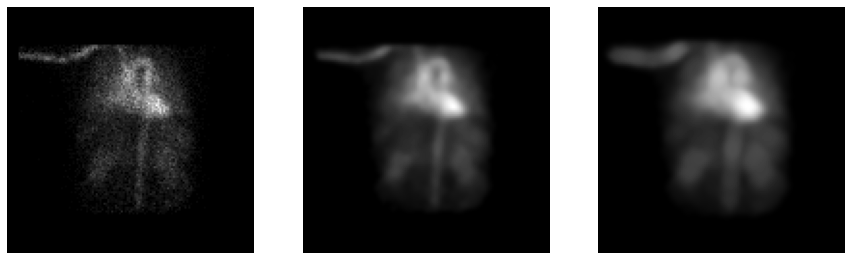

In [61]:
im = mean[5,:,:]
im = (255*(im.astype(np.float)/max(np.unique(im)))).astype(np.uint8)
med = gaussian(median(im, disk(3)))
im_processed = gaussian(maximum(med, disk(2)),1)

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(med, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(im_processed, cmap=plt.cm.gray)
plt.show()

#image.imsave('template.png', med, cmap=plt.cm.gray)

In [62]:
@interact(rad=IntSlider(min=0, max=50, step=1, value=10),  
          am=IntSlider(min=0, max=50, step=1, value=10),
          thresh=FloatSlider(min=0, max=1, step=0.01, value=0.9),
          im1 = fixed(im),
          im2 = fixed(im_processed))

def unsharp_segmentation(rad, am, thresh, im1, im2):
    local1 = unsharp_mask(im1, radius=rad, amount=am)*ell
    local2 = unsharp_mask(im2, radius=rad, amount=am)*ell
    local_morpho = closing(opening(local2, disk(5)), disk(5))


    plt.figure(figsize=[15,15])
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(local1, cmap=plt.cm.gray)
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(local2, cmap=plt.cm.gray)
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(local_morpho, cmap=plt.cm.gray)
    plt.subplot(1,4,4)
    plt.axis('off')
    plt.imshow(im)
    plt.imshow(local_morpho>thresh, cmap='bwr', alpha=0.3)
    plt.show()

interactive(children=(IntSlider(value=10, description='rad', max=50), IntSlider(value=10, description='am', ma…

# Liver uptake rate calcul

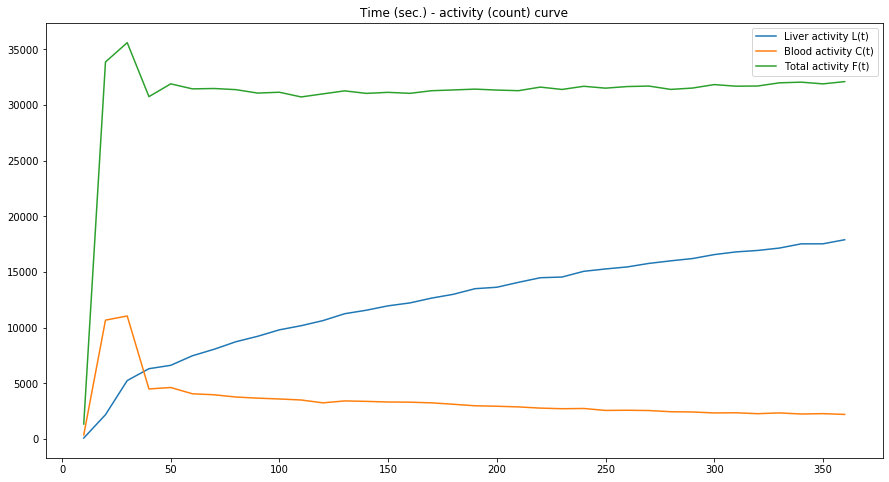

In [137]:
Lt = [75.22620206727042, 2171.6573873702037, 5240.058948964823, 6305.619571225982, 6607.721187184377, 
      7467.63367652685, 8053.170138852807, 8728.399722965907, 9216.42997469495, 9796.257192785464,
      10168.453806260755, 10624.295471130426, 11244.278590127613, 11559.879614734511, 11952.890712249471,
      12214.89474244861, 12648.103696731334, 12989.665926454853, 13493.978216861064, 13622.649235630475, 
      14066.917649478708, 14478.0181932679, 14542.018106621368, 15055.057892415993, 15266.997264601103, 
      15448.778303455118, 15767.03870079609, 15995.396593331285, 16200.973542529746, 16555.99972206792, 
      16799.543250210325, 16929.518449270337, 17144.46144060582, 17523.037645862783, 17525.437111308405, 
      17891.400293477927]

Ct = [351.7478164809896, 10668.544173216298, 11041.909114799568, 4484.668198489293, 4615.396316119048,
      4050.5709571712932, 3961.431601556106, 3758.899246596461, 3658.4869589222994, 3584.147897469105,
      3493.4851656959213, 3236.405206875266, 3409.554193212917, 3368.8555790379555, 3312.8815705198476,
      3296.167375905381, 3237.14336786035, 3109.0503908364, 2973.3958061535586, 2932.497745293502,
      2871.4733213814893, 2763.9361436574854, 2709.5256008464426, 2729.894468384449, 2556.0603424999467,
      2572.139191459586, 2546.353984364498, 2437.87357881079, 2415.9131966233995, 2329.807919957175,
      2345.0464706162034, 2261.6112781373927, 2332.7807017711716, 2233.532323806138, 2265.9857216221876,
      2197.9735204531275]

Ft = [1329.9157661663705, 33866.50767965961, 35597.35628606755, 30751.190575755667, 31898.107456356636,
      31447.3596818183, 31480.413591949604, 31377.319302048836, 31069.876190633655, 31145.344453515052,
      30722.75454881914, 30997.38099517003, 31268.679886806756, 31041.903015141776, 31135.78783291517,
      31045.77176539461, 31281.540568151828, 31352.083305213077, 31424.831097522976, 31339.79923302326,
      31285.354125446735, 31606.75220384242, 31395.846002779363, 31680.40515009864, 31511.89936071931,
      31656.517820026485, 31699.983655547407, 31399.58358705967, 31519.86707557144, 31831.91267752663,
      31688.262780412322, 31704.287466512564, 31990.330283461182, 32050.59106958875, 31896.500479975053,
      32100.04089303943]

time_steps = [10*(i+1) for i in range(36)]

plt.figure(figsize=[15,8])
plt.title('Time (sec.) - activity (count) curve')
plt.plot(time_steps, Lt, label = 'Liver activity L(t)')
plt.plot(time_steps, Ct, label = 'Blood activity C(t)')
plt.plot(time_steps, Ft, label = 'Total activity F(t)')
plt.legend()
plt.show()

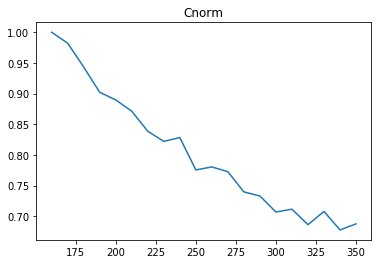

A(t1) : 22204.11463547662
Area under the curve : 152.1133688408396
Liver clearance rate : 10.08397%/min
Corrected uptake rate for BSA of 1.71m^2 : 5.90569%/min/m^2


In [138]:
def sec2min(sec):
    m = sec//60
    m += (sec%60)/60.0
    return(m)

def bsa(w,h):
    return((h*w/3600)**(1/2)) # Mosteller

def calcul_inte(ft1, ft2, lt1, lt2, ct, time_steps):
    Cnorm = np.array(ct)/ct[0]
    plt.plot(time_steps, Cnorm)
    plt.title('Cnorm')
    plt.show()

    At1 = (ft2-lt1-(ft1-lt1)*Cnorm[-1])/(1-Cnorm[-1]) #Ekman eq. 8
    print('A(t1) :', At1)

    integral = trapz(Cnorm, time_steps)
    print('Area under the curve :', integral)

    LClr = 60*(lt2-lt1)/(At1*integral) #Ekman eq. 4
    print('Liver clearance rate : {:.5f}%/min'.format(LClr*100))

    corrected = LClr/bsa(64, 164)
    print('Corrected uptake rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), corrected*100))
    
calcul_inte(Ft[15], Ft[35], Lt[15], Lt[35], Ct[15:35], time_steps[15:35])

# Tc99m decay correction

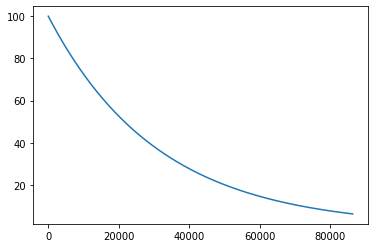

Time   Activity   Corr factor
150     0.9952      1.0048
160     0.9949      1.0051
170     0.9946      1.0055
180     0.9942      1.0058
190     0.9939      1.0061
200     0.9936      1.0064
210     0.9933      1.0068
220     0.9930      1.0071
230     0.9926      1.0074
240     0.9923      1.0077
250     0.9920      1.0081
260     0.9917      1.0084
270     0.9914      1.0087
280     0.9911      1.0090
290     0.9907      1.0093
300     0.9904      1.0097
310     0.9901      1.0100
320     0.9898      1.0103
330     0.9895      1.0106
340     0.9891      1.0110
350     0.9888      1.0113


In [139]:
l = 0.69315/(6*60*60)
x = [i for i in range(0,24*60*60,2)]
y = [100*np.exp(-l*i) for i in x]
plt.plot(x,y)
plt.show()

print('Time   Activity   Corr factor')
for i in time_steps[14:35]:
    print('{}     {:.4f}      {:.4f}'.format(i, 1*np.exp(-l*i), 1/np.exp(-l*i)))

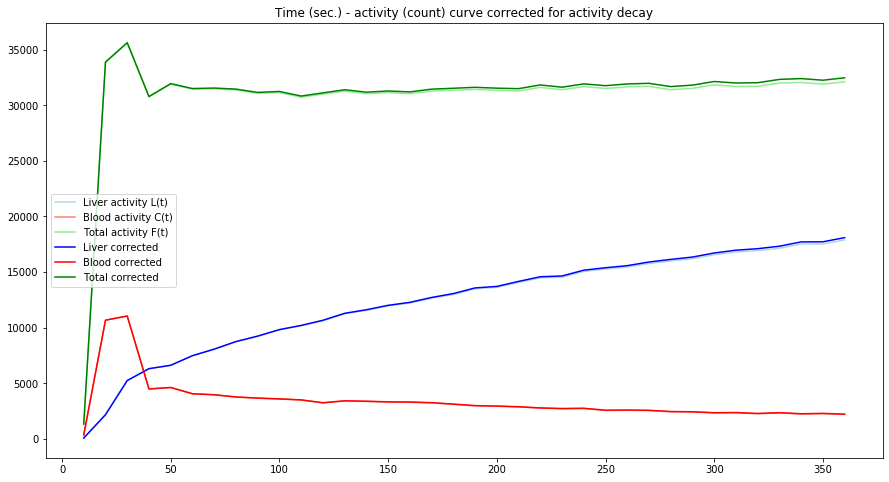

In [140]:
Lt_corr = [Lt[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]
Ct_corr = [Ct[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]
Ft_corr = [Ft[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]

plt.figure(figsize=[15,8])
plt.title('Time (sec.) - activity (count) curve corrected for activity decay')
plt.plot(time_steps, Lt, label = 'Liver activity L(t)', color = 'lightblue')
plt.plot(time_steps, Ct, label = 'Blood activity C(t)', color = 'salmon')
plt.plot(time_steps, Ft, label = 'Total activity F(t)', color = 'lightgreen')
plt.plot(time_steps, Lt_corr, label = 'Liver corrected', color = 'blue')
plt.plot(time_steps, Ct_corr, label = 'Blood corrected', color = 'red')
plt.plot(time_steps, Ft_corr, label = 'Total corrected', color = 'green')
plt.legend()
plt.show()

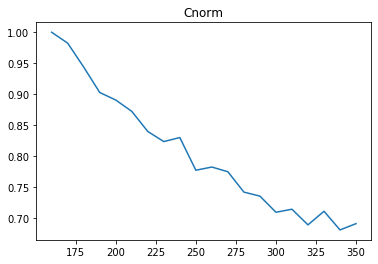

A(t1) : 23034.718979155863
Area under the curve : 152.5470863585596
Liver clearance rate : 9.93873%/min
Corrected uptake rate for BSA of 1.71m^2 : 5.82063%/min/m^2


In [141]:
calcul_inte(Ft_corr[15], Ft_corr[35], Lt_corr[15], Lt_corr[35], Ct_corr[15:35], time_steps[15:35])

# Uptake rate calcul with Bcl

C0 : 4507.91646
lambda : 0.00209
t1/2 : 332.03469

Blood clearence rate : 12.52544%/min
Liver clearance rate : 9.37745%/min

Blood corrected at : 7.33555%/min/m^2
Liver corrected rate for BSA of 1.71m^2 : 5.49192%/min/m^2


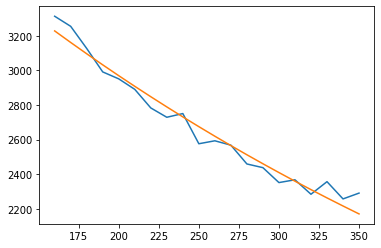

In [142]:
from scipy.optimize import curve_fit # BCl[t] = c0*e^(-l*t)

def calcul_fit_free(ct1, ct2, lt1, lt2, ft1, ft2, time_steps, ct):
    plt.plot(time_steps, ct)
    popt, pcov = curve_fit(lambda t,c0,l: c0*np.exp(-l*t), time_steps, ct,[3000, 0.001])
    print('C0 : {:.5f}'.format(popt[0]))
    print('lambda : {:.5f}'.format(popt[1]))
    plt.plot(time_steps, [popt[0]*np.exp(-popt[1]*i) for i in time_steps])
    tdemi = 0.693147/popt[1]
    print('t1/2 : {:.5f}'.format(tdemi))

    bcl = 0.693147/tdemi
    print()
    print('Blood clearence rate : {:.5f}%/min'.format(bcl*100*60))
    cnormt2 = ct2/ct1
    at1 = (ft2-lt1-(ft1-lt1)*cnormt2)/(1-cnormt2)
    inte = (np.exp(-bcl*150)-np.exp(-bcl*350))/(bcl*(np.exp(-bcl*150)))
    lcl = (lt2-lt1)/(at1*inte)

    print('Liver clearance rate : {:.5f}%/min'.format(lcl*100*60))
    print()
    print('Blood corrected at : {:.5f}%/min/m^2'.format(bcl*100*60/bsa(64, 164)))
    print('Liver corrected rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), (lcl*100*60)/bsa(64, 164)))
    
calcul_fit_free(Ct_corr[15], Ct_corr[35], Lt_corr[15], Lt_corr[35], 
                 Ft_corr[15],  Ft_corr[35], time_steps[15:35], Ct_corr[15:35])

fixed C0 : 3312.60
lambda : 0.00090
t1/2 : 767.54377

Blood clearence rate : 5.41843%/min
Liver clearance rate : 8.37920%/min

Blood corrected at : 3.17331%/min/m^2
Liver corrected rate for BSA of 1.71m^2 : 4.90729%/min/m^2


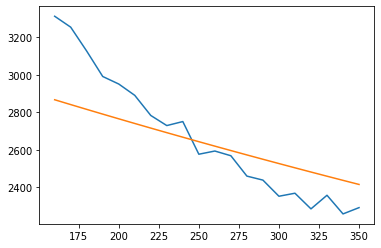

In [143]:
def calcul_fit_cons(ct1, ct2, lt1, lt2, ft1, ft2, time_steps, ct):
    plt.plot(time_steps, ct)
    popt, pcov = curve_fit(lambda t,l: ct1*np.exp(-l*t), time_steps, ct,[0.001])
    print('fixed C0 : {:.2f}'.format(ct1))
    print('lambda : {:.5f}'.format(popt[0]))
    plt.plot(time_steps, [ct1*np.exp(-popt[0]*i) for i in time_steps])
    tdemi = 0.693147/popt[0]
    print('t1/2 : {:.5f}'.format(tdemi))

    bcl = 0.693147/tdemi
    print()
    print('Blood clearence rate : {:.5f}%/min'.format(bcl*100*60))
    cnormt2 = ct2/ct1
    at1 = (ft2-lt1-(ft1-lt1)*cnormt2)/(1-cnormt2)
    inte = (np.exp(-bcl*150)-np.exp(-bcl*350))/(bcl*(np.exp(-bcl*150)))
    lcl = (lt2-lt1)/(at1*inte)

    print('Liver clearance rate : {:.5f}%/min'.format(lcl*100*60))
    print()
    print('Blood corrected at : {:.5f}%/min/m^2'.format(bcl*100*60/bsa(64, 164)))
    print('Liver corrected rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), (lcl*100*60)/bsa(64, 164)))
    
calcul_fit_cons(Ct_corr[15], Ct_corr[35], Lt_corr[15], Lt_corr[35], 
                 Ft_corr[15],  Ft_corr[35], time_steps[15:35], Ct_corr[15:35])

# Respi adjustments

In [1]:
avg_last10_f64 = np.zeros(mean[-1].shape, dtype=np.float64)
for i in range(len(mean[-10:])):
    avg_last10_f64 += mean[-i]
avg_last10_f64 = avg_last10_f64/10
avg_last10_u8 = f64_2_u8(avg_last10_f64)
liv_med = median(avg_last10_u8, disk(2))
liv_thresh = threshold_otsu(liv_med)
liv_mask = liv_med > liv_thresh-10
liv_mask = closing(liv_mask, disk(3))
masked_liv = np.ma.masked_where(liv_mask==0, liv_mask)
shifted = [0 for i in range(len(mean))]

for im in range(len(mean)):
    tot = np.sum(masked_liv*mean[im])
    for i in range(1,6):
        shifted_liv = ndimage.shift(masked_liv, [i,0])
        shifted_liv = closing(shifted_liv,disk(3))
        shifted_liv = np.ma.masked_where(shifted_liv==0, shifted_liv)
        if np.sum(shifted_liv*mean[im])>tot:
            tot=np.sum(shifted_liv*mean[im])
            print('{} shifted to {}'.format(im, i))
            shifted[im] = i

print(shifted)
interact(show_im,i=IntSlider(min=0, max=35, step=1, value=0),
         mask=fixed(masked_liv), shift=fixed(shifted))

NameError: name 'np' is not defined

# Write Dicom

In [5]:
with pd.dcmread("Images/Dyn_Ant_HBS1.dcm") as ant:
    #ant.decompress()
    ant_pix = ant.pixel_array
    print(type(ant))
    print(type(ant.PixelData))
    print(ant.file_meta.TransferSyntaxUID)
    print(ant.BitsAllocated)
    print()
    
    print(ant_pix.shape, ant_pix.dtype)
    print(np.unique(ant_pix))
    print(np.sum(ant_pix))
    print()

    mean = np.round(mean).astype(np.uint16)
    ant[0x0018, 0x0070].value = np.sum(mean)
    print(mean.shape)
    print(np.unique(mean))
    print(np.sum(mean))
    
    ant.PixelData = mean.tobytes()
    ant.save_as('Images/new.dcm')

<class 'pydicom.dataset.FileDataset'>
<class 'bytes'>
1.2.840.10008.1.2.1
16

(36, 128, 128) uint16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 85 86 87 89 90 91 95 96]
1549255

(36, 128, 128)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 78 80 96]
914155


uint16
(1252, 2379)
21 255 227
uint16
(1252, 2379)
0 255 256
uint16
(2, 1252, 2379)


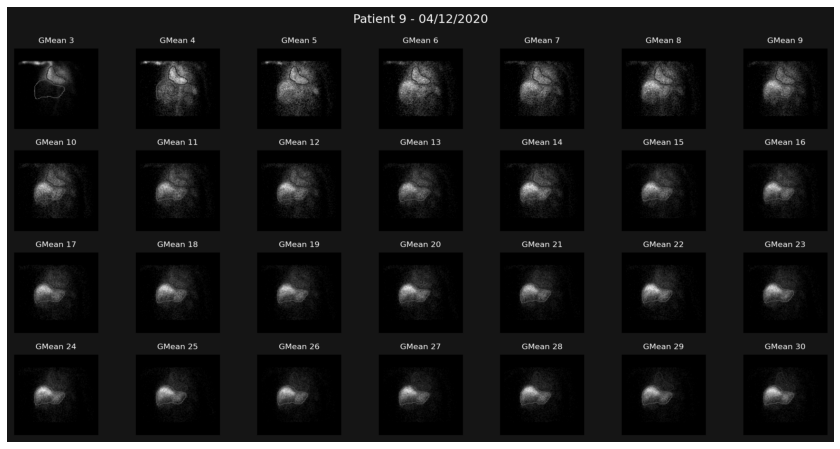

In [41]:
with pd.dcmread("Images/Dyn_Ant_HBS1.dcm") as ant:
    im = io.imread("Prefix_timeSeries.png")
    im_gray_1 = rgb2gray(rgba2rgb(im))
    im_gray_1 = (im_gray_1*255).astype(np.uint16)
    #plt.figure(figsize=(15,8))
    #plt.axis('off')
    #plt.imshow(im_gray, cmap=plt.cm.gray)
    print(im_gray_1.dtype)
    print(im_gray_1.shape)
    print(min(np.unique(im_gray_1)),max(np.unique(im_gray_1)), len(np.unique(im_gray_1)))
    
    im = io.imread("Prefix_slices.png")
    im = resize(im, im_gray_1.shape)
    im_gray_2 = rgb2gray(rgba2rgb(im))
    im_gray_2 = (im_gray_2*255).astype(np.uint16)
    #plt.figure(figsize=(15,8))
    #plt.axis('off')
    #plt.imshow(im_gray_2, cmap=plt.cm.gray)
    print(im_gray_2.dtype)
    print(im_gray_2.shape)
    print(min(np.unique(im_gray_2)),max(np.unique(im_gray_2)), len(np.unique(im_gray_2)))
    
    arr = np.empty((2,im_gray_1.shape[0],im_gray_1.shape[1]), dtype=np.uint16)
    arr[0] = im_gray_2
    arr[1] = im_gray_1
    print(arr.dtype)
    print(arr.shape)
    
    ant[0x0018, 0x0070].value = np.sum(arr)                      #tot_count
    ant[0x0028, 0x0010].value = im_gray_1.shape[0]               #rows
    ant[0x0028, 0x0011].value = im_gray_1.shape[1]               #columns
    ant[0x0028, 0x0008].value = 2                                #slices
    ant.PixelData = arr.tobytes()
    ant.save_as('Images/new.dcm')

In [193]:
print(avg_blood.dtype, max(np.unique(avg_blood)))
print(avg_blood_norm.dtype, max(np.unique(avg_blood_norm)))
x = gaussian(median(avg_blood_norm, disk(5)), 1)
print(x.dtype, max(np.unique(x)))

float64 34.20491559048054
uint8 255
float64 0.41141879178590324
